## PHOTOMETRIC CALIBRATION IN PHOEBE

In this tutorial we will explore basic photometric properties of observed objects as built into PHOEBE, along with the implementation rationale. First let's import all the modules we will need along the way:

In [1]:
import phoebe
import numpy as np
import astropy.units as u
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pyplot as plt

Set up some useful plotting defaults:

In [2]:
mpl.rcParams['figure.figsize'] = (16, 6)
mpl.rcParams['font.sans-serif'] = 'Arial, Liberation Sans, DejaVu Sans, Bitstream Vera Sans, sans-serif'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 16

### Background.

When measuring incident light from a source, there are several radiative properties that we need to distinguish:

* Luminosity: net power emitted by the source. It is an aspect-independent scalar, measured in Watts or in the number of photons.
* Intensity: emergent monochromatic radiant energy per unit time from a differential surface element:

$$ I(\lambda) = \frac{dE(\lambda)}{dA \cos \theta d\lambda dt d\Omega} $$

Intensity is aspect-dependent and measured in $\mathrm{Watts}/\mathrm{m}^2/\mathrm{m}$ or $\mathrm{photons}/\mathrm{m}^2/\mathrm{m}$.

* Flux density: integrated intensity over all directions:

$$ f_\lambda (\lambda) \equiv \frac{df}{d\lambda} = \int_\theta I(\lambda) \cos \theta d\Omega. $$

Flux density is aspect-independent and measured in $\mathrm{Watts}/\mathrm{m}^2/\mathrm{m}$ or $\mathrm{photons}/\mathrm{m}^2/\mathrm{m}$.

* Flux: integrated flux density over all wavelengths:

$$ f = \int_\lambda f_\lambda (\lambda) d\lambda. $$

It is measured in in $\mathrm{Watts}/\mathrm{m}^2$ or $\mathrm{photons}/\mathrm{m}^2$.

When observing, the measured physical quantity from an unresolved source is *flux*; the measured physical quantity from a resolved source is *intensity*. Note also that intensity is distance-independent whereas flux is inversely proportional to the square of the distance.

Detectors of course cannot measure bolometric flux -- they are inherently limited to the small region of the overall spectrum that can pass from the source to the detector. That region depends on the source itself (its spectral energy distribution), of anything in-between the source and the optics (interstellar extinction, atmospheric extinction), of the optics itself (reflectivity, absorption, scattering, diffraction on optical elements), and on the quantum efficiency of the CCD. Each of these effects alters the incoming spectral energy distribution and each has its own corresponding response functon. The response function tells us what happens to the uniformly distributed light over all wavelengths when passed through the optical element. A product of all response functions forms a net response function that we call a *passband*; it can also be called a *bandpass* but PHOEBE uses the former consistently.

Given an input of uniform flux density, a passband transmission function determines flux density transmission at each wavelength. Transmission of 0 means no light gets through, transmission of 1 means all light gets through. Let us take a look at Johnson B and V passbands as an example:

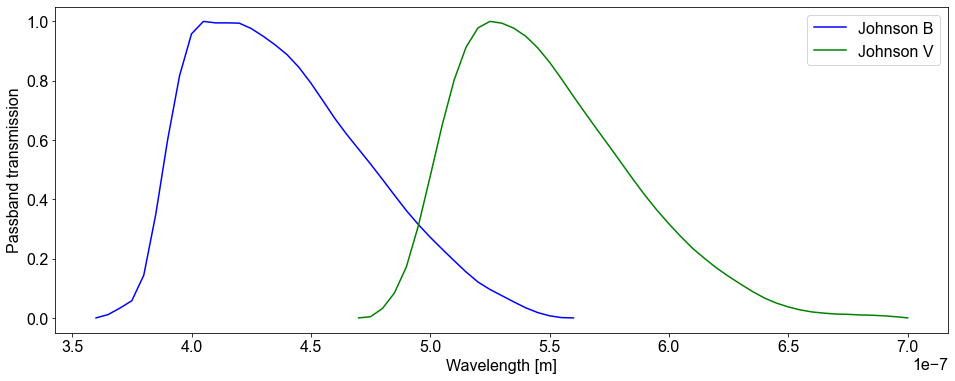

In [3]:
jB = phoebe.get_passband('Johnson:B')
jV = phoebe.get_passband('Johnson:V')

plt.xlabel('Wavelength [m]')
plt.ylabel('Passband transmission')
plt.plot(jB.ptf_table['wl'], jB.ptf_table['fl'], 'b-', label='Johnson B')
plt.plot(jV.ptf_table['wl'], jV.ptf_table['fl'], 'g-', label='Johnson V')
plt.legend()

Now let's read in theoretical spectral energy distributions (SEDs) of 4 spectral types (M, G, A and B) as calculated by Castelli & Kurucz (2004)'s model atmospheres. If you are running this notebook from the cloned workshop repository, you are all set; otherwise you will need to download supporting files from [this link](http://phoebe-project.org/static/flux_calibration_files.tgz). Once you have downloaded them, unpack the archive into the same directly where the notebook is and you will be all set.

In [4]:
import numpy as np
from astropy.io import fits

sptypes = ['M3 V', 'G2 V', 'A0 V', 'B0 V']
spcolors = ['r', 'g', 'y', 'b']
spectra = [
    'T03500G50P00.fits',
    'T05750G45P00.fits',
    'T10000G40P00.fits',
    'T25000G40P00.fits'
]

wls = np.arange(900., 39999.501, 0.5)/1e10 # AA -> m
seds = np.empty((len(wls), len(spectra)))
for i, (sptype, spectrum) in enumerate(zip(sptypes, spectra)):
    with fits.open(spectrum) as hdul:
        seds[:,i] = hdul[0].data[-1,:]*1e7  # erg/s/cm^2/A -> W/m^3

Stars of different spectral types will of course differ vastly in their flux densities. In all functions below we will compute quantities for all spectral types, but we will focus on the G2 spectral type and then let you compare the results for other spectral types. To begin, let's plot the SED:

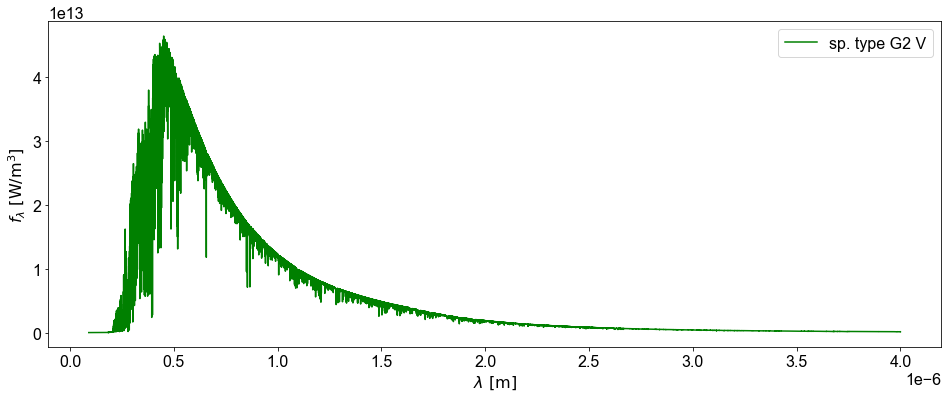

In [5]:
plt.xlabel('$\lambda \ [\mathrm{m}]$')
plt.ylabel('$f_\lambda \ [\mathrm{W}/\mathrm{m}^3]$')
plt.plot(wls, seds[:,1], f'g-', label=f'sp. type G2 V')
plt.legend(loc='upper right')
plt.show()

Now we can take a closer look at the parts covered by the Johnson B and V passbands:

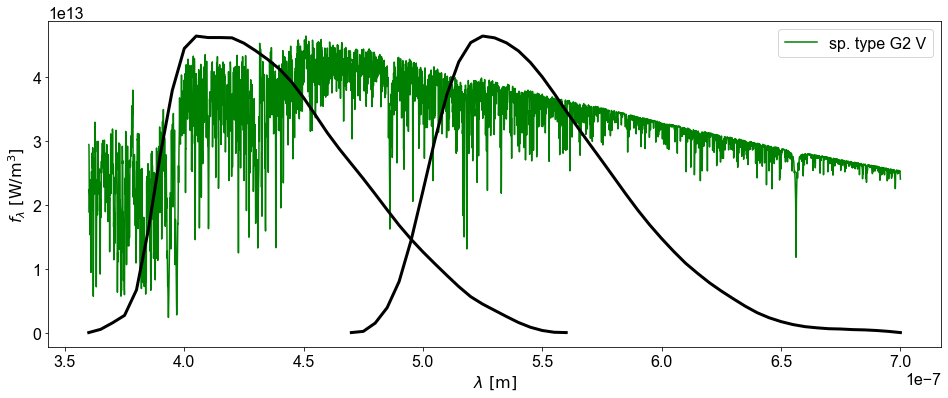

In [6]:
flt = (wls >= jB.ptf_table['wl'][0]) & (wls <= jV.ptf_table['wl'][-1])
fwls = wls[flt]
fseds = seds[flt]

plt.xlabel('$\lambda \ [\mathrm{m}]$')
plt.ylabel('$f_\lambda \ [\mathrm{W}/\mathrm{m}^3]$')

plt.plot(fwls, fseds[:,1], 'g-', label=f'sp. type G2 V')
plt.plot(jB.ptf_table['wl'], fseds[:,1].max()*jB.ptf_table['fl'], 'k-', lw=3)
plt.plot(jV.ptf_table['wl'], fseds[:,1].max()*jV.ptf_table['fl'], 'k-', lw=3)
plt.legend(loc='upper right')

When doing photometry, the underlying SED is *unknown*, and the quantity we measure is the number of photons detected on a CCD in a given amount of time. In other words, we measure the *integral* of the passband transmission function times spectral energy distribution function over passband wavelengths:

$$ f = \frac{1}{hc} \int_\lambda \lambda f_\lambda(\lambda) P(\lambda) d\lambda. $$

Confused about the $\lambda/hc$ term? This is because we are measuring *photon* flux and not *energy* flux. As $E = hc/\lambda$, $f_P = (\lambda/hc) f_E$. Note that this $f$ is an actual flux (i.e., we can convert it to $\mathrm{W}/\mathrm{m}^2$). Let's compute the integrand and plot it, to get a better idea of what we're integrating:

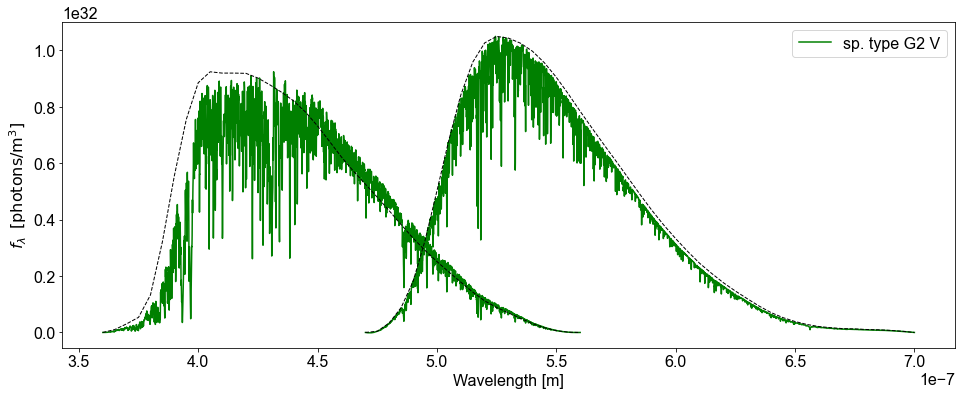

In [8]:
hc = 1.98644586e-25

flt_B = (wls >= jB.ptf_table['wl'][0]) & (wls <= jB.ptf_table['wl'][-1])
fwls_B = wls[flt_B]
fseds_B = seds[flt_B]
integrands_B = (fwls_B*jB.ptf(fwls_B))[:,np.newaxis]*fseds_B/hc

flt_V = (wls >= jV.ptf_table['wl'][0]) & (wls <= jV.ptf_table['wl'][-1])
fwls_V = wls[flt_V]
fseds_V = seds[flt_V]
integrands_V = (fwls_V*jV.ptf(fwls_V))[:,np.newaxis]*fseds_V/hc

plt.xlabel('Wavelength [m]')
plt.ylabel('$f_\lambda \,\,\, [\mathrm{photons/m}^3]$')

plt.plot(fwls_B, integrands_B[:,1], 'g-', label=f'sp. type G2 V')
plt.plot(fwls_V, integrands_V[:,1], 'g-')

plt.plot(jB.ptf_table['wl'], integrands_B[:,1].max()*jB.ptf_table['fl'], 'k--', lw=1)
plt.plot(jV.ptf_table['wl'], integrands_V[:,1].max()*jV.ptf_table['fl'], 'k--', lw=1)
plt.legend(loc='upper right')

Plotted with dashed lines are the passband transmission functions for B (left) and V (right) filters. You might expect that the transmitted SED should be enclosed by the passband response function, but that is evidently not the case: the reason is in the weighting by $\lambda$ in the integrand.

**Exercise: plot the same type of graph as above, but for the energy-weighted case; how do you interpret the result?** Note that $f = \int_\lambda f_\lambda(\lambda) P(\lambda) d\lambda.$

The *flux* measurement is the integral of this integrand; let's compute it!

In [9]:
dwl = wls[1]-wls[0]
fl_B = np.sum(integrands_B[:,1])*dwl
fl_V = np.sum(integrands_V[:,1])*dwl
print(f'flux in B-band: {fl_B:.3e} photons/m^2\nflux in V-band: {fl_V:.3e} photons/m^2')

flux in B-band: 7.150e+24 photons/m^2
flux in V-band: 8.236e+24 photons/m^2


**Exercise: calculate energy-weighted fluxes; what units are your results in?**

So can we switch back and forth between photon flux and energy flux if we do not have the underlying SED? No, we cannot, at least not exactly. The reason is simple: when we count photons, we do not know what energy they carried, only how many there were; if we measure energy, we do not know how many photons provided that energy. The transformation between the two thus has to rely on some underlying assumptions on the SED and its properties. And this is all in an idealized case where quantum efficiency of detectors is flux-independent, which we know not to be true. Pixel sensitivity varies (and can vary significantly!) during image exposure, which further complicates the transformation.

The main takeaway from this is: *if you do not need to transform photon flux to/from energy flux, then don't*.

But say we do need to do it (and we will get into the whys in just a bit). What is the best way to get that done? We already wrote the relationship between energy flux and photon flux:

$$ f_P = \frac{\lambda}{hc} f_E. $$

The issue here is, what $\lambda$ do we take? Central passband wavelength? Some weighted median? Enter the concept of *effective wavelengths*.

### Effective wavelength

An effective wavelength of a passband is the wavelength that, when properly weighted by all contributions to the flux and integrated over the wavelength span, will yield the same flux as the SED itself. A *true* effective wavelength of the passband is thus given by:

$$ \lambda_\mathrm{eff} = \frac{\int_\lambda \lambda f_\lambda (\lambda) P(\lambda) d\lambda}{\int_\lambda f_\lambda (\lambda) P(\lambda) d\lambda}. $$

Therefore, $\lambda_\mathrm{eff}$ depends on the entire optical system (via $P(\lambda)$) *and* the observed source (via $f_\lambda (\lambda))$. In other words, $\lambda_\mathrm{eff}$ will be different for different objects that we are observing through the same filter on the same observational setup. That in-and-of-itself should make you raise an eyebrow as it implies that $\lambda_\mathrm{eff}$ is *not* a well defined quantity. In fact, filter manufacturers define $\lambda_\mathrm{eff}$ for the filter response by itself, observatories provide it for the optical system (corrected for the atmosphere), and we need to account for the SED integrand as well, which is generally *unknown* (unless you are doing absolute spectroscopy). Thus, we *hope* that the absence of $f_\lambda (\lambda)$ and the downscaled $P(\lambda)$ won't change the integrals by much.

Let us explore this in more detail. We can compute an effective wavelength for several scenarios. First, let's load two additional response curves: that of Earth's atmosphere, and that of an off-the-shelf CCD.

In [10]:
atm = phoebe.atmospheres.passbands.Passband(
    ptf='atmosphere.dat',
    pbset='Earth',
    pbname='atmosphere',
    effwl=550.0,
    wlunits=u.nm,
    calibrated=True,
    reference='',
    version=1.0,
    comments='',
    oversampling=1,
    ptf_order=3,
    from_file=False
)

qe = phoebe.atmospheres.passbands.Passband(
    ptf='ccd_qe.dat',
    pbset='CCD',
    pbname='QE',
    effwl=550.0,
    wlunits=u.nm,
    calibrated=True,
    reference='',
    version=1.0,
    comments='',
    oversampling=1,
    ptf_order=3,
    from_file=False
)

In reality, the passband *should* already account for the quantum efficiency and atmospheric extinction *should* be corrected during data reduction, but this situation is unusually common, *especially* for QE. For the sake of the argument assume that observations are not atmosphere-corrected and that the passband contains optics and filter response, but no CCD's quantum efficiency. How do all these contributions affect effective wavelength? For the record, the filter manufacturer quotes $\lambda_\mathrm{eff} = 440$ nm for the B-band and $\lambda_\mathrm{eff} = 550$ nm for the V-band.

In [11]:
def effwl(wls, pb, qe, atm, sed):
    print(f'{pb.pbset.upper()} {pb.pbname.upper()}:')
    print('-'*43)
    # only filter response:
    wleff = (wls*pb.ptf(wls)).sum()/pb.ptf(wls).sum()
    print(f'filter only:              wleff = {1e9*wleff:2.2f} nm')

    # filter + QE:
    wleff = (wls*pb.ptf(wls)*qe.ptf(wls)).sum()/(pb.ptf(wls)*qe.ptf(wls)).sum()
    print(f'filter + QE:              wleff = {1e9*wleff:2.2f} nm')

    # filter + QE + atm:
    wleff = (wls*pb.ptf(wls)*qe.ptf(wls)*atm.ptf(wls)).sum()/(pb.ptf(wls)*qe.ptf(wls)*atm.ptf(wls)).sum()
    print(f'filter + QE + atm:        wleff = {1e9*wleff:2.2f} nm')

    # filter + SED:
    wleff = (wls*sed*pb.ptf(wls)).sum()/(sed*pb.ptf(wls)).sum()
    print(f'filter + SED:             wleff = {1e9*wleff:2.2f} nm')

    # filter + SED + QE:
    wleff = (wls*sed*pb.ptf(wls)*qe.ptf(wls)).sum()/(sed*pb.ptf(wls)*qe.ptf(wls)).sum()
    print(f'filter + SED + QE:        wleff = {1e9*wleff:2.2f} nm')

    # filter + SED + QE + atm:
    wleff = (wls*sed*pb.ptf(wls)*qe.ptf(wls)*atm.ptf(wls)).sum()/(sed*pb.ptf(wls)*qe.ptf(wls)*atm.ptf(wls)).sum()
    print(f'filter + SED + QE + atm:  wleff = {1e9*wleff:2.2f} nm')

    print('')

effwl(fwls_B, jB, qe, atm, fseds_B[:,1])
effwl(fwls_V, jV, qe, atm, fseds_V[:,1])

JOHNSON B:
-------------------------------------------
filter only:              wleff = 438.59 nm
filter + QE:              wleff = 442.00 nm
filter + QE + atm:        wleff = 451.25 nm
filter + SED:             wleff = 442.53 nm
filter + SED + QE:        wleff = 445.69 nm
filter + SED + QE + atm:  wleff = 454.23 nm

JOHNSON V:
-------------------------------------------
filter only:              wleff = 549.06 nm
filter + QE:              wleff = 548.55 nm
filter + QE + atm:        wleff = 555.36 nm
filter + SED:             wleff = 547.09 nm
filter + SED + QE:        wleff = 546.73 nm
filter + SED + QE + atm:  wleff = 553.22 nm



Inspecting these values should make it clear that $\lambda_\mathrm{eff}$ is indeed poorly defined, most notably because it depends on the *unknown* SED of the observed object. Ignoring it for Sun-like stars causes systematic errors of ~1%.

**Exercise: using `effwl()` defined above and changing the SED index, evaluate the impact of different spectral types on $\lambda_\mathrm{eff}$ and figure out where the spread is the largest.**

Now let's load another Johnson V filter, kindly provided by Phill Reed from Kutztown.

In [12]:
import astropy.units as u

jV1 = phoebe.atmospheres.passbands.Passband(
    ptf='jv.kutztown.ptf',
    pbset='Johnson',
    pbname='V1',
    effwl=550.0,
    wlunits=u.nm,
    calibrated=True,
    reference='',
    version=1.0,
    comments='',
    oversampling=1,
    ptf_order=3,
    from_file=False
)

This filter is being sold as Johnson V, so let's compare its transmission curve and effective wavelengths:

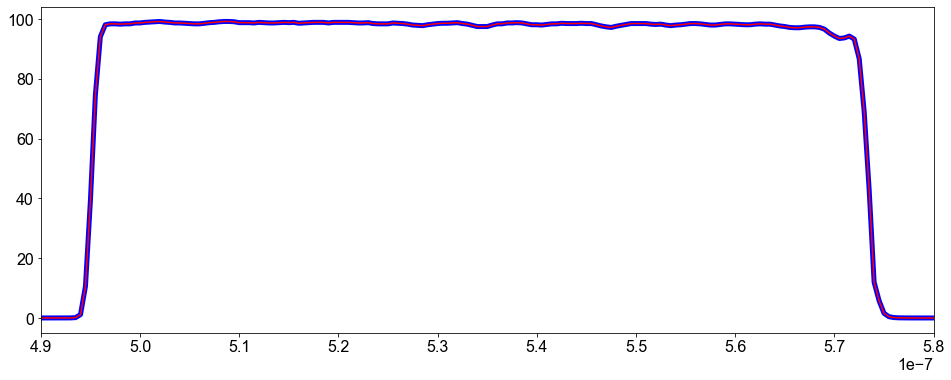

In [13]:
plt.xlim(4.9e-7, 5.8e-7)
plt.plot(jV1.ptf_table['wl'], jV1.ptf_table['fl'], 'b-', lw=5)
plt.plot(jV1.ptf_table['wl'], jV1.ptf(jV1.ptf_table['wl']), 'r-')

In [14]:
# flt = (wls >= pb.ptf_table['wl'][0]) & (wls <= pb.ptf_table['wl'][-1])
flt_V1 = (wls >= 4.9e-7) & (wls <= 5.8e-7)
fwls_V1 = wls[flt_V1]
fseds_V1 = seds[flt_V1]

effwl(fwls_V1, jV1, qe, atm, fseds_V1[:,1])

JOHNSON V1:
-------------------------------------------
filter only:              wleff = 534.12 nm
filter + QE:              wleff = 534.53 nm
filter + QE + atm:        wleff = 537.33 nm
filter + SED:             wleff = 533.50 nm
filter + SED + QE:        wleff = 533.92 nm
filter + SED + QE + atm:  wleff = 536.74 nm



Scratching your head yet over how (in)appropriate $\lambda_\mathrm{eff}$ is for precision photometry?

### Flux or flux density?

When we observe a photometric source, the signal that we measure -- as established above -- is given in photons per meter squared. Thus, it has the units of flux. Yet frequently you will find photometric calibrations providing flux densities, measured in photons per meter *cubed*. How can that be?

Given the observed *passband flux*, we can define a *monochromatic flux density* as:

$$ \langle f_\lambda \rangle = \frac{\int_\lambda \lambda f_\lambda P(\lambda) d\lambda}{\int_\lambda \lambda P(\lambda) d\lambda}. $$

You can think of $\langle f_\lambda \rangle$ as flux density of a source that emits equally at all wavelengths. Thus, $\langle f_\lambda \rangle$ is wavelength-independent; to go back to flux:

$$ f = \frac{1}{hc} \int_\lambda \lambda f_\lambda (\lambda) P(\lambda) d\lambda = \langle f_\lambda \rangle \frac{1}{hc} \underbrace{\int_\lambda \lambda P(\lambda) d\lambda}_{\textrm{ptf photon area}} = \langle f_\lambda \rangle \frac{1}{hc} A_\mathrm{ptf}. $$

This is significant because $A_\mathrm{ptf}$ can be (and is in PHOEBE) computed in advance and stored in the passband class.

Let's compute $\langle f_\lambda \rangle$ for our case and see what that gives us:

Computed photon-weighted area: hc*4.00318e-14
Stored photon-weighted area:   hc*4.00318e-14
B-band <f_lambda>:             3.54819e+13 photons/m^3
V-band <f_lambda>:             3.47566e+13 photons/m^3


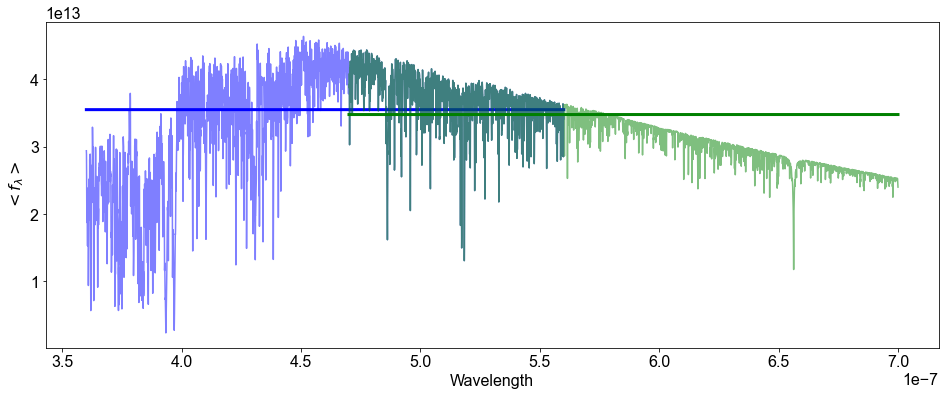

In [15]:
# compute the photon area manually and read it out from the passband file; they must match:
ptf_photon_area_B = np.sum(fwls_B*jB.ptf(fwls_B))*(fwls_B[1]-fwls_B[0])
print(f'Computed photon-weighted area: hc*{ptf_photon_area_B:.5e}')
print(f'Stored photon-weighted area:   hc*{jB.ptf_photon_area:.5e}')

# compute mean (monochromatic) flux densities:
fld_B = fl_B/jB.ptf_photon_area*hc
fld_V = fl_V/jV.ptf_photon_area*hc
print(f'B-band <f_lambda>:             {fld_B:.5e} photons/m^3')
print(f'V-band <f_lambda>:             {fld_V:.5e} photons/m^3')

# overplot the original SEDs and monochromatic flux densities:
plt.xlabel('Wavelength')
plt.ylabel('$<f_\lambda>$')
plt.plot(fwls_B, fseds_B[:,1], 'b-', alpha=0.5)
plt.plot(fwls_B, np.ones_like(fseds_B[:,1])*fld_B, 'b-', lw=3)
plt.plot(fwls_V, fseds_V[:,1], 'g-', alpha=0.5)
plt.plot(fwls_V, np.ones_like(fseds_V[:,1])*fld_V, 'g-', lw=3)
plt.show()

It is precisely these values that PHOEBE pre-computes and stores in the lookup tables:

In [16]:
fld_B_phoebe = jB.Inorm(atm='ck2004', Teff=5750, logg=4.5, abun=0, photon_weighted=True)[0]
fld_V_phoebe = jV.Inorm(atm='ck2004', Teff=5750, logg=4.5, abun=0, photon_weighted=True)[0]
print(f"B-band <f_lambda>: {fld_B_phoebe:.5e} photons/m^3")
print(f"V-band <f_lambda>: {fld_V_phoebe:.5e} photons/m^3")

B-band <f_lambda>: 3.54819e+13 photons/m^3
V-band <f_lambda>: 3.47566e+13 photons/m^3


**Exercise: calculate energy-weighted mean flux densities and compare them to the values from PHOEBE. What units do these values have?**

### Magnitudes?

Magnitudes are an astronomer's way to measure *fluxes*. In general,

$$ m - m_0 = -\frac 52 \log_{10} \frac{f}{f_0}, $$

where $m_0$ is the reference magnitude that corresponds to the flux $f_0$. Fluxes are measured in $\textrm{W}/\textrm{m}^2$ while magnitudes are unitless. The ($m_0$, $f_0$) pair is usually chosen so that $m_0=0$ for a prescribed value of $f_0$. That really is all that there is to magnitudes. 

Consider observations of a given star, say Vega, in two photometric passbands, say B and V. As we saw in our discussion above, the fluxes in the B band and in the V band are in general _different_. Add another photometric passband, say R, and the three fluxes will _definitely_ be different: there is no stellar spectral energy distribution function that would have the same integrals under all three passbands. Yet, as far as magnitudes are concerned, it is customary to define $m_0$ *per passband*: in other words, each passband comes with its own $m_0$. These passband-dependent $m_0$ are referred to as *photometric zero-points*. In the past people used Vega to set *all* magnitudes to be equal at all wavelengths (conversely, all color indices by definition equal 0). Today people no longer use Vega, instead they prescribe an exact passband-dependent $f_0$ that uniquely defines $m_0$.

Now consider the specifics of the observatory where data are acquired. Each site has its own optics, insturmentation, sky above them, each unique. Thus, when photons are counted, this count will be observatory-specific even when observed in the same filter, say Johnson B or V. If these fluxes are instrumental, then magnitudes derived from them will be instrumental as well, and we ideally want to be able to compare them to the magnitudes reported from other sites. For that purpose we need *photometric standards*: stars that have been calibrated by a reference system that tells us how many photons should we have gathered in a given passband. For example, a standard star HD 315 has its magnitudes published as $V=6.44$ and $B=6.295$. If we measure $V_\mathrm{instr} = 6.24$ and $B_\mathrm{instr} = 6.495$, we can compute the suitable corrections, thus transforming our instrumental magnitudes to the reference system. As demonstrated above, passband flux depends on the spectral type, so we want to calibrate our instrumental magnitudes with comparison stars that are as similar to the target of interest as possible. For each used passband we need one reference zero-point to standardize our measurements. Those can then be compared with equally standardized measurements from other observatories. The most significant standard of the last Century are [Landolt stars](https://ui.adsabs.harvard.edu/abs/1992AJ....104..340L/abstract).

So what happens when we observe in a photometric passband that is *not* covered by the standard? In that case we can first transform flux to the monochromatic (mean) flux density (cf. discussion of the mean flux density above):

$$ f_\lambda^\mathrm{instr} = \frac{\int_\lambda \lambda f_\lambda (\lambda) P(\lambda) d\lambda}{\int_\lambda \lambda P(\lambda) d\lambda} = \frac{f_\mathrm{pb}^\mathrm{instr}}{\int_\lambda \lambda P(\lambda) d\lambda}, $$

where $f_\lambda$ is the (unknown) SED of the observed calibration source and $P(\lambda)$ is the local passband response. This instrumental flux density is *passband-independent*: it is a constant value across the entire wavelength span. If integrated over the passband weighted-response, it would yield the same integral as the source. Recent standards calibrate flux *densities* instead. For example:

* **AB magnitude system**: it represents a monochromatic flux per unit frequency, assuming a flat reference spectrum $f_\nu \equiv df/d\nu$. A light source that has $f_\nu = 3.63 \times 10^{-20}$ erg/$\textrm{cm}^2/\textrm{s}/\textrm{Hz}$ will have the corresponding ABmag=0 in all passbands. The corresponding zero-point is $m_{AB} = 48.6$, which will of course change if units are different.

$$ \mathrm{ABmag} = -2.5 \log_{10} f_\nu - 48.6. $$

* **ST magnitude system**: it represents a monochromatic flux per unit wavelength, assuming a flat reference spectrum $f_\lambda \equiv df/d\lambda$. A light source that has $f_\lambda = 3.63 \times 10^{-9} \mathrm{erg}/\textrm{cm}^2/\textrm{s}/\AA$ will have the corresponding STmag=0 in all passbands. The corresponding zero-point is $m_{ST} = 21.10$.

$$ \mathrm{STmag} = -2.5 \log_{10} f_\lambda - 21.10. $$

As before, if we have $f_\lambda^\mathrm{instr}$ and we look up what the reference $f_\lambda$ should be, we can easily find a mapping $f_\lambda^\mathrm{instr} \mapsto f_\lambda$. If we ever wanted to convert this back to flux, we would need to undo this transformation:

$$ f = \frac{1}{hc} \int_\lambda \lambda \langle f_\lambda \rangle P(\lambda) d\lambda $$

for whatever passband $P(\lambda)$. Of course, we need to be consistent in what we use to transform intrumental fluxes to instrumental flux densities: we need to use the same to go the opposite way. Transformation to magnitudes (flux) or monochromatic magnitudes (flux density) bears no relevance here -- it is just a different representation of the same units.

The bottom line: if you have standardized monochromatic magnitudes on an AB or an ST system, you need to first convert them back to fluxes for your particular passband, by either multiplying them by the passband photon area, or by whatever was used in the reduction/calibration process from instrumental magnitudes to AB/ST magnitudes (most commonly effective wavelength). From the previous discussion you should know why that might not be a good idea.

### Spectral type dependence

This tutorial should have armed you with an understanding of the intricacies involved in photometric data acquisition and calibration, and how PHOEBE treats photometric data under the hood. For conclusion, let's take a look at the comparison between the 4 spectral types. Fortunately, we have been computing quantities for all spectral types all along, so we can take a look without too much extra effort.

Let's start by plotting a maximum-normalized SEDs for all 4 spectral types:

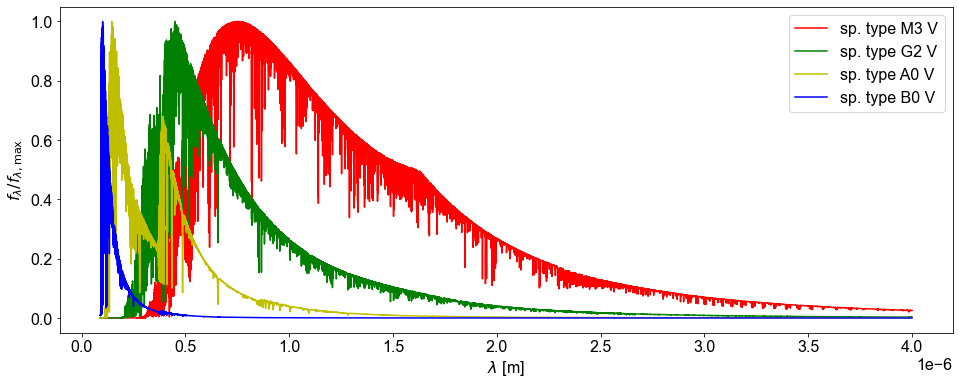

In [17]:
plt.xlabel('$\lambda$ [m]')
plt.ylabel('$f_\lambda/f_{\lambda,\mathrm{max}}$')
for i, c in enumerate(spcolors):
    plt.plot(wls, seds[:,i]/max(seds[:,i]), f'{c}-', label=f'sp. type {sptypes[i]}')
plt.legend(loc='upper right')

This showcases how the peak of the SED curve shifts to the red with later spectral types. Limiting the wavelength span to Johnson B and V passbands:

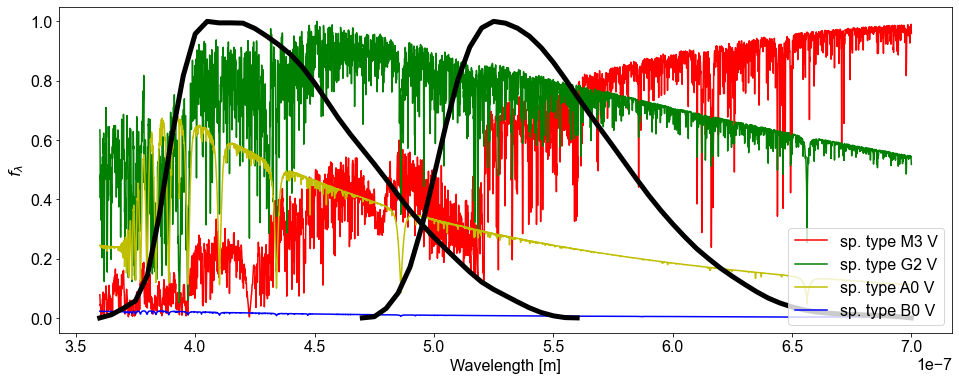

In [18]:
plt.xlabel('Wavelength [m]')
plt.ylabel('$f_\lambda$')

for i, c in enumerate(spcolors):
    plt.plot(fwls, fseds[:,i]/max(seds[:,i]), f'{c}-', label=f'sp. type {sptypes[i]}')

plt.plot(jB.ptf_table['wl'], jB.ptf_table['fl'], 'k-', lw=5)
plt.plot(jV.ptf_table['wl'], jV.ptf_table['fl'], 'k-', lw=5)
plt.legend(loc='lower right')

Note that the relative flux density of each spectral type is normalized to the maximum flux density, which can be outside the visible interval (i.e. for spectral types B0 and M3). This does *not* mean that the B0 star is the faintest in the optical. If we were to plot the actual flux densities, we would get a completely different picture:

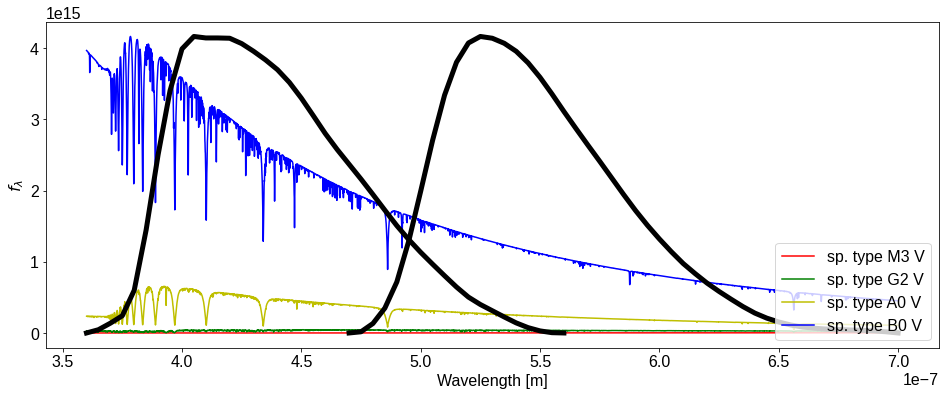

In [21]:
plt.xlabel('Wavelength [m]')
plt.ylabel('$f_\lambda$')

for i, c in enumerate(spcolors):
    plt.plot(fwls, fseds[:,i], f'{c}-', label=f'sp. type {sptypes[i]}')

plt.plot(jB.ptf_table['wl'], max(fseds[:,3])*jB.ptf_table['fl'], 'k-', lw=5)
plt.plot(jV.ptf_table['wl'], max(fseds[:,3])*jV.ptf_table['fl'], 'k-', lw=5)
plt.legend(loc='lower right')

Likewise, if we were to normalize flux densities to their peak *within* this wavelength interval:

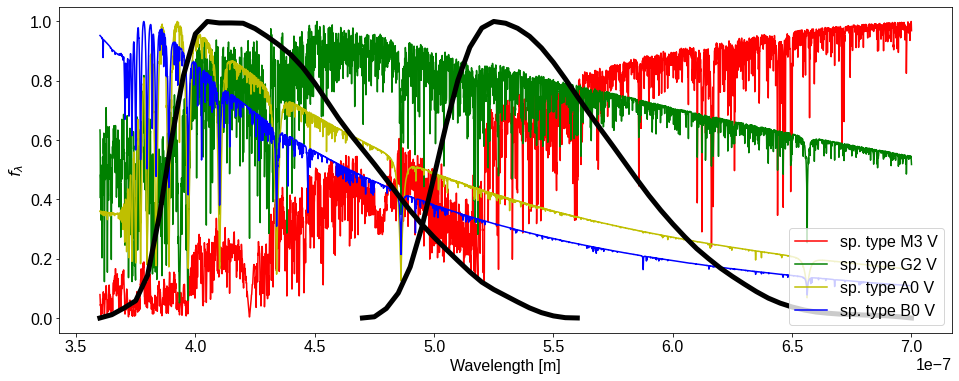

In [22]:
plt.xlabel('Wavelength [m]')
plt.ylabel('$f_\lambda$')

for i, c in enumerate(spcolors):
    plt.plot(fwls, fseds[:,i]/max(fseds[:,i]), f'{c}-', label=f'sp. type {sptypes[i]}')

plt.plot(jB.ptf_table['wl'], jB.ptf_table['fl'], 'k-', lw=5)
plt.plot(jV.ptf_table['wl'], jV.ptf_table['fl'], 'k-', lw=5)
plt.legend(loc='lower right')

This is arguably the most useful representation for what we are actually measuring. 

**Exercise: calculate passband intensities for all spectral types and make sure that they are consistent with PHOEBE.**

**Exercise: take spectral type A0 to be your reference spectrum. Let $B=V=0$ for it by definition. Calculate $B-V$ color indices for all other spectral types and compare them to the values from the literature.**